<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [5]:
w_init = initializers.glorot_normal()
b_init = initializers.Zeros()

# model = Sequential()
# model.add(Dense(n_dense,
#                 input_dim=n_input,
#                 kernel_initializer=w_init,
#                 bias_initializer=b_init))
# model.add(Activation('sigmoid'))

In [6]:
model = tf.keras.Sequential()

drop_out = 0.2
lern_rat = 0.00001
neurons = 64

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(neurons * 1, activation='relu', kernel_initializer=w_init, bias_initializer=b_init)) #, kernel_regularizer=regularizers.l2(lern_rat)
# model.add(BatchNormalization())
# model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons * 2, activation='tanh'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 4, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 8, activation='tanh'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(10, activation='softmax'))

In [7]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # sparse_categorical_accuracy

1/1 [==============================] - 1s 795ms/step


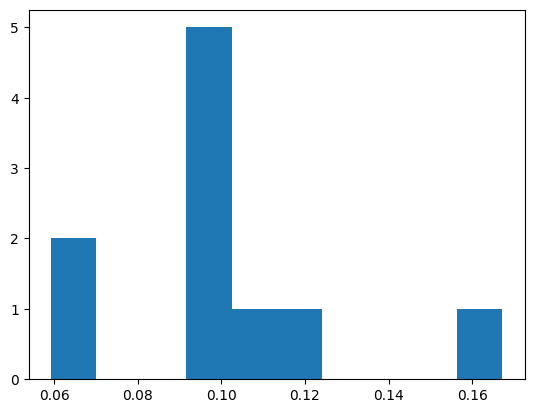

In [8]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [9]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=12)

In [10]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=120,
                    batch_size=64,
                    callbacks=[callback],
                    verbose=1, #многословие
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/120
782/782 [==============================] - 28s 25ms/step - loss: 0.7639 - accuracy: 0.7306 - val_loss: 0.4974 - val_accuracy: 0.8221
Epoch 2/120
782/782 [==============================] - 11s 14ms/step - loss: 0.5572 - accuracy: 0.7987 - val_loss: 0.4456 - val_accuracy: 0.8339
Epoch 3/120
782/782 [==============================] - 11s 14ms/step - loss: 0.4907 - accuracy: 0.8224 - val_loss: 0.4053 - val_accuracy: 0.8508
Epoch 4/120
782/782 [==============================] - 9s 12ms/step - loss: 0.4611 - accuracy: 0.8313 - val_loss: 0.3942 - val_accuracy: 0.8539
Epoch 5/120
782/782 [==============================] - 11s 14ms/step - loss: 0.4321 - accuracy: 0.8404 - val_loss: 0.3702 - val_accuracy: 0.8647
Epoch 6/120
782/782 [==============================] - 11s 14ms/step - loss: 0.4144 - accuracy: 0.8477 - val_loss: 0.3574 - val_accuracy: 0.8685
Epoch 7/120
782/782 [==============================] - 11s 14ms/step - loss: 0.3996 - accuracy: 0.8524 - val_loss: 0.3442 - val_acc

In [11]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


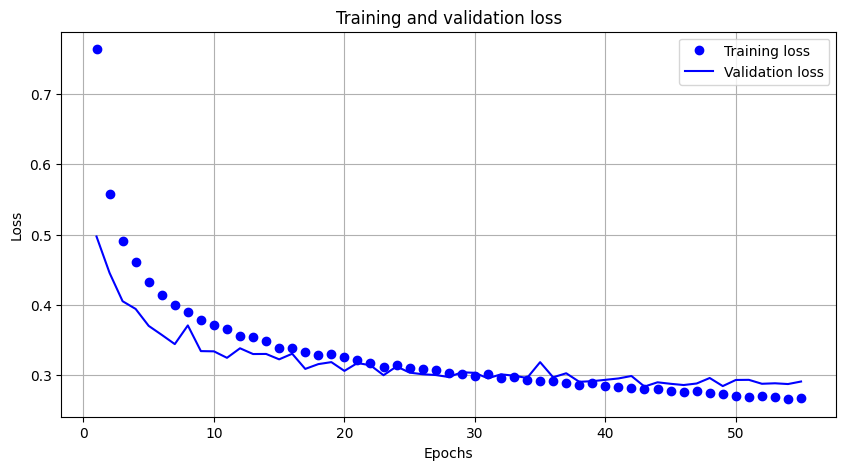

<Figure size 640x480 with 0 Axes>

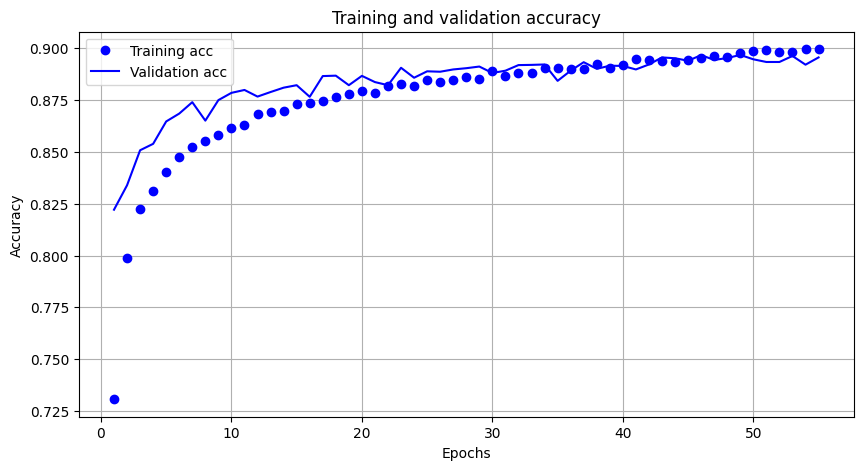

In [12]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [13]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [14]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [15]:
predictions[0]

array([0.08542667, 0.0854267 , 0.08542667, 0.08542673, 0.08542667,
       0.08544482, 0.08542667, 0.08602846, 0.0854267 , 0.23053986],
      dtype=float32)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        